In [1]:
import torch
import numpy as np

import random
import copy
import os
import pickle

import cl_gym as cl
from metrics import MetricCollector2, FairMetricCollector
from configs import make_params

std_datasets = ["MNIST", "FashionMNIST", "CIFAR10", "CIFAR100"]

In [14]:
def load(dataset, seed, epoch, lr, tau, alpha, lmbd, joint=False, finetune=False, verbose=0):
    log_dir = f"scripts_output/dataset={dataset}"
    target_dir = f"seed={seed}_epoch={epoch}_lr={lr}"
    if joint:
        log_dir = os.path.join(log_dir, "joint")
    elif finetune:
        log_dir = os.path.join(log_dir, "finetune")
    else:
        target_dir+=f"_tau={tau}_alpha={alpha}"
        if alpha != 0 and dataset not in std_datasets:
            target_dir+=f"_lmbd={lmbd}_lmbdold={0.0}"

    if not target_dir in os.listdir(log_dir):
        for dir in os.listdir(log_dir):
            if target_dir in dir:
                target_dir = dir
                break

    # print(f"{target_dir=}")
    log_dir = os.path.join(log_dir, target_dir)
    # print(f"{log_dir=}")
    out = os.path.join(log_dir, "log.out")
    err = os.path.join(log_dir, "log.err")
    if os.path.exists(err):
        with open(err, "r") as f:
            lines = f.readlines()
        if len(lines):
            if verbose:
                print(f"Error in {target_dir} - error during running")
                for line in lines:
                    print(line)
            return False
    else:
        if verbose:
            print(f"error in {target_dir} - not exists")
        return False
    return target_dir

def check_running(dataset, target_dir, joint=False, finetune=False):
    log_dir = f"scripts_output/dataset={dataset}"
    if joint:
        log_dir = os.path.join(log_dir, "joint")
    elif finetune:
        log_dir = os.path.join(log_dir, "finetune")
    log_dir = os.path.join(log_dir, target_dir)        
    out = os.path.join(log_dir, "log.out")
    if os.path.exists(out):
        with open(out, "r") as f:
            lines = f.readlines()
    if len(lines) == 0:
        return True
    else:
        return False


def load_log(dataset, target_dir, joint=False, finetune=False):
    log_dir = f"scripts_output/dataset={dataset}"
    if joint:
        log_dir = os.path.join(log_dir, "joint")
    elif finetune:
        log_dir = os.path.join(log_dir, "finetune")
    log_dir = os.path.join(log_dir, target_dir)      
    # print(f"load_log_log_{log_dir=}")  
    out = os.path.join(log_dir, "log.out")
    acc, fairness = 0, 0
    if os.path.exists(out):
        with open(out, "r") as f:
            lines = f.readlines()
        if "accuracy" in lines[-2]:
            acc = float(lines[-2].strip().split(":")[-1])
        elif "accuracy" in lines[-3]:
            acc = float(lines[-3].strip().split(":")[-1])
        if "fairness" in lines[-1]:
            fairness = float(lines[-1].strip().split(":")[-1])
        elif "fairness" in lines[-2]:
            fairness = float(lines[-2].strip().split(":")[-1])
    else:
        print(f"{out=} not exists")
    if acc * fairness == 0:
        print(f"{out=} : wrong output")
    return acc, fairness

def load_metrics(dataset, target_dir, joint=False, finetune=False, validation=False):
    metrics_dir = f"outputs/dataset={dataset}"
    if joint:
        metrics_dir = os.path.join(metrics_dir, "joint")
    elif finetune:
        metrics_dir = os.path.join(metrics_dir, "finetune")

    metrics_dir = os.path.join(metrics_dir, target_dir)
    if not os.path.exists(metrics_dir):
        metrics_dir = metrics_dir.replace("lmbd=", "lmbd_")
        metrics_dir = metrics_dir.replace("lmbdold=", "lmbdold_")
    out = os.path.join(metrics_dir, "plots/output.txt")

    if validation:
        if os.path.exists(out):
            with open(out, "r") as f:
                lines = f.readlines()
            for i, line in enumerate(lines):
                if i == 0:
                    continue
                if "acc" in line:
                    acc = float(lines[i+1].strip())
        else:
            print(f"{out=} not exists")
        if acc != load_log(dataset, target_dir, joint=joint, finetune=finetune)[0]:
            print(acc)
            print(load_log(dataset, target_dir, joint=joint, finetune=finetune)[0])
            raise ValueError
    
    metrics_dir = os.path.join(metrics_dir, "metrics/metrics.pickle")
    with open(metrics_dir, "rb") as f:
        metric_manager_callback = pickle.load(f)
    return metric_manager_callback

In [13]:
def get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, \
             joint=False, finetune = False, verbose=0):
    acc_list = list()
    fair_list = list()
    info_list = list()
    fair_metric = "multiclass_eo"
    if dataset in std_datasets:
        lambda_range = [0]
        fair_metric = "std"
    # MNIST
    for tau in tau_range:
        for lr in lr_range:
            for alpha in alpha_range:
                for lmbd in lambda_range:
                    cnt = 0
                    acc_sum = 0
                    fair_sum = 0
                    info = f"tau={tau}/lr_{lr}/alpha_{alpha}"
                    # print(f"{info=}")
                    avail_seed = copy.deepcopy(seed_range)
                    for seed in seed_range:
                        target_dir = load(dataset, seed, epoch, lr, tau, alpha, lmbd, joint=joint, finetune=finetune)
                        # print(f"{target_dir=}")
                        if not target_dir or check_running(dataset, target_dir, joint=joint, finetune=finetune):
                            avail_seed.remove(seed)
                            # print(seed)
                            # print(target_dir)
                            continue
                        acc, fair = load_log(dataset, target_dir, joint=joint, finetune=finetune)
                        if acc*fair == 0:
                            avail_seed.remove(seed)
                            # print(seed)
                            # print(target_dir)
                            continue
                        mmc = load_metrics(dataset, target_dir, joint=joint, finetune=finetune)
                        
                        acc = np.mean(mmc.meters['accuracy'].compute_overall())
                        fair = np.mean(mmc.meters[fair_metric].compute_overall())
                        acc_sum+=acc
                        fair_sum+=fair
                        cnt+=1
                    info = f"tau={tau}/lr_{lr}/alpha_{alpha}({cnt=}, {avail_seed})"
                    if cnt == 0:
                        print(f"{info=}: check if boom?")
                        continue

                    info_list.append(info)
                    acc_list.append(acc_sum/cnt)
                    fair_list.append(fair_sum/cnt)
                    out = f"{info}\n{acc_sum/cnt}\n{fair_sum/cnt}"
                    if verbose:
                        print(out)
    if verbose:
        print()
    
    integrated_score = [e - 2*fair_list[i] for i, e in enumerate(acc_list)]
    idx = integrated_score.index(max(integrated_score))
    print(f"{info_list[idx]}")
    accuracy = acc_list[idx]
    fairness = fair_list[idx]

    if accuracy > 1:
        accuracy /= 100
    print(f"acc:{accuracy}")
    print(f"fair:{fairness}")
    return info_list, acc_list, fair_list


In [4]:
import matplotlib.pyplot as plt

def plot(acc_list, fair_list, marker = "o"):
    plt.scatter(acc_list, fair_list, marker=marker, s = 10)
    plt.xlabel('acc')
    plt.ylabel('fairness')

In [25]:
def display(dataset, epoch, size = 20):
    print("joint")
    tau_range = [0.0]
    # lr_range = [0.01, 0.001]
    lr_range = [0.01]
    alpha_range = [0.0]
    lambda_range = [0.0]
    seed_range = [0, 1, 2, 3, 4]

    joint_info_list, joint_acc_list, joint_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, joint=True)
    plt.scatter(joint_acc_list, joint_fair_list, marker='o', s = size)

    print("finetune")
    tau_range = [0.0]
    alpha_range = [0.0]
    lambda_range = [0.0]
    seed_range = [0, 1, 2, 3, 4]
    finetune_info_list, finetune_acc_list, finetune_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, finetune=True)
    # plt.scatter(finetune_acc_list, finetune_fair_list, marker='x', s = size)


    print("baseline")
    tau_range = [1.0, 5.0, 10.0]
    alpha_range = [0.0]
    lambda_range = [1.0, 5.0, 10.0]
    seed_range = [0, 1, 2, 3, 4]

    base_info_list, base_acc_list, base_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range)
    plt.scatter(base_acc_list, base_fair_list, marker='v', s = size)

    print("FSS")
    tau_range = [1.0, 5.0, 10.0]
    alpha_range = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02]
    lambda_range = [1.0, 5.0, 10.0]
    seed_range = [0, 1, 2, 3, 4]

    fss_info_list, fss_acc_list, fss_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range)
    for i, e in enumerate(fss_info_list):
        print(e, fss_acc_list[i], fss_fair_list[i])
    plt.scatter(fss_acc_list, fss_fair_list, marker='x', s = size)

    target_baseline = [e - 2*base_fair_list[i] for i, e in enumerate(base_acc_list)]
    idx = target_baseline.index(max(target_baseline))
    base_fair_max = base_fair_list[idx]
    base_acc_min = base_acc_list[idx]
    plt.xlim([base_acc_min-5, 100])
    if dataset != "BiasedMNIST":
        plt.ylim([0, base_fair_max+5])
    else:
        plt.ylim([0, base_fair_max+0.15])

    plt.xlabel('acc')
    if dataset in std_datasets:
        plt.ylabel('std')
    else:
        plt.ylabel('eo')

joint
tau=0.0/lr_0.01/alpha_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.9983304863795738
fair:0.14933021666816648
finetune
tau=0.0/lr_0.01/alpha_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.4523180688926259
fair:35.568904520630575
baseline
tau=1.0/lr_0.01/alpha_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.8698767352907629
fair:11.228693063690304
FSS
tau=5.0/lr_0.01/alpha_0.02(cnt=5, [0, 1, 2, 3, 4])
acc:0.905857934936087
fair:4.273835567191297
tau=1.0/lr_0.01/alpha_0.0005(cnt=5, [0, 1, 2, 3, 4]) 89.61659087143985 7.457126979317957
tau=1.0/lr_0.01/alpha_0.001(cnt=5, [0, 1, 2, 3, 4]) 89.61659087143985 7.457126979317957
tau=1.0/lr_0.01/alpha_0.002(cnt=5, [0, 1, 2, 3, 4]) 89.88545281417899 7.11955603833276
tau=1.0/lr_0.01/alpha_0.005(cnt=5, [0, 1, 2, 3, 4]) 90.00558687569323 6.813806383550523
tau=1.0/lr_0.01/alpha_0.01(cnt=5, [0, 1, 2, 3, 4]) 90.80027754937946 5.047120819043936
tau=1.0/lr_0.01/alpha_0.02(cnt=5, [0, 1, 2, 3, 4]) 89.8982939407789 4.438975915017279
tau=5.0/lr_0.01/alpha_0.0005(cnt=5, [0, 1, 2, 3, 4]) 88.904

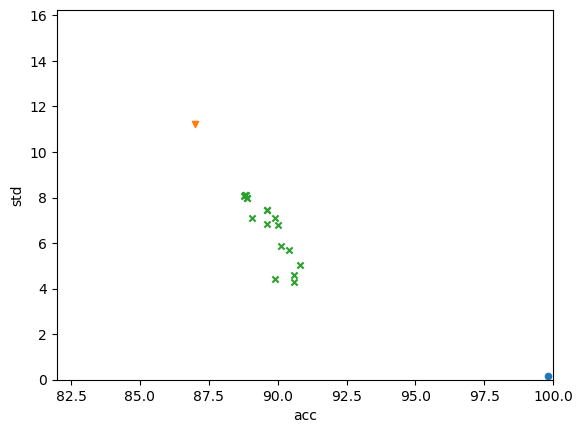

In [27]:
dataset = "MNIST"
epoch = 1
display(dataset, epoch)

In [21]:
dataset = "MNIST"
epoch = 5
display(dataset, epoch)

'MNIST'

5

In [22]:
dataset = "MNIST"
epoch = 15
display(dataset, epoch)

'MNIST'

15

gss
tau=10.0/lr_0.001/alpha_0.0(cnt=3, [0, 1, 2])
acc:0.8997930219411
fair:8.992843276014758


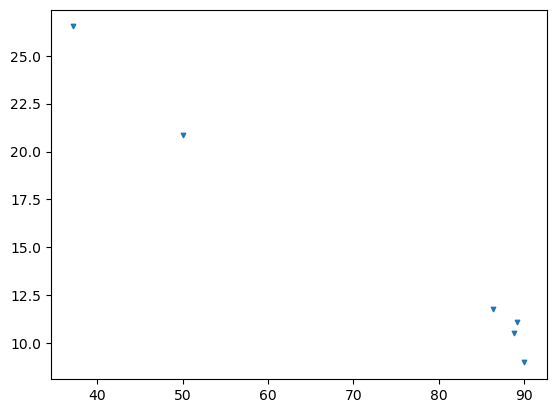

In [28]:
print("gss")
dataset = "MNIST"
epoch = 1
tau_range = [1.0, 5.0, 10.0]
alpha_range = [0.0]
lr_range = [0.01, 0.001]
lambda_range = [0.0]
seed_range = [0, 1, 2]

base_info_list, base_acc_list, base_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range)
plt.scatter(base_acc_list, base_fair_list, marker='v', s = 10)


info='tau=10.0/lr_0.01/alpha_0.0005(cnt=0, [])': check if boom?
tau=10.0/lr_0.001/alpha_0.0005(cnt=5, [0, 1, 2, 3, 4])
acc:90.88502809963326
fair:0.11815474016805165


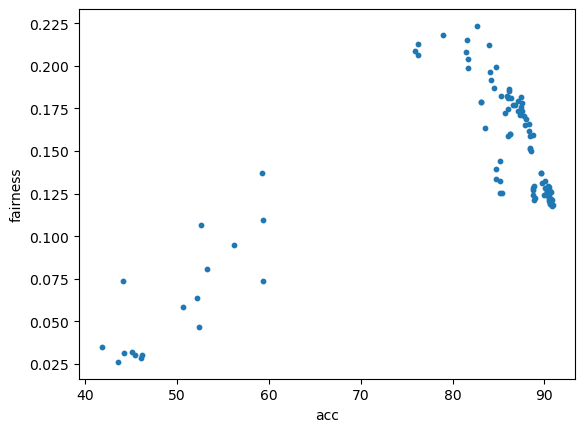

In [47]:
tau_range = [1.0, 5.0, 10.0]
lr_range = [0.01, 0.001]
alpha_range = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02]
lambda_range = [1.0, 5.0, 10.0]
seed_range = [0, 1, 2, 3, 4]


info_list, acc_list, fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range)
plot(acc_list, fair_list)

tau=10.0/lr_0.001/alpha_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:92.12401062137107
fair:1.8570647306931811


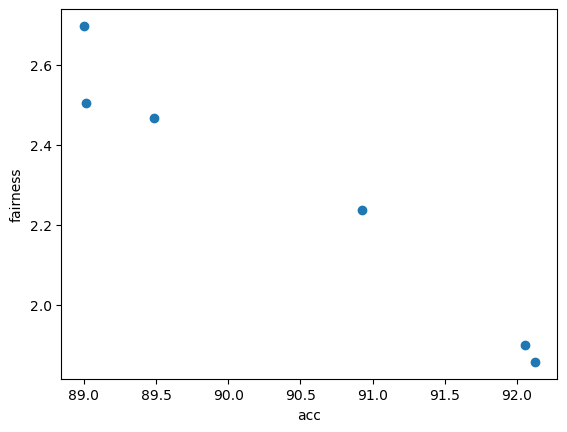

In [13]:
tau_range = [1.0, 5.0, 10.0]
lr_range = [0.01, 0.001]
alpha_range = [0.0]
lambda_range = [1.0, 5.0, 10.0]
seed_range = [0, 1, 2, 3, 4]

info_list, acc_list, fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range)
plot(acc_list, fair_list)

tau=0.0/lr_0.001/alpha_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:99.78665827564505
fair:0.07237256135934844


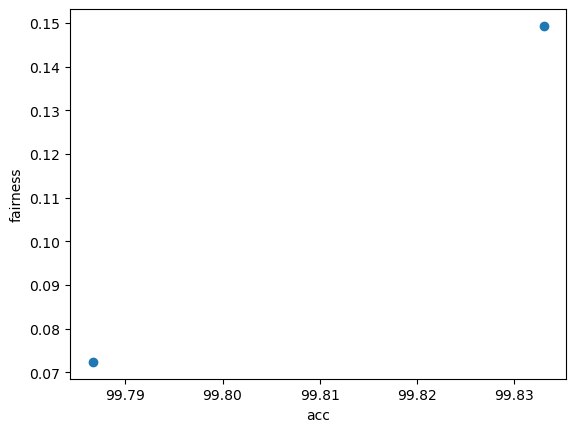

In [14]:
tau_range = [0.0]
lr_range = [0.01, 0.001]
alpha_range = [0.0]
seed_range = [0, 1, 2, 3, 4]

info_list, acc_list, fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, joint=True)
plot(acc_list, fair_list)

In [168]:
tau_range = [1.0, 5.0, 10.0]
lr_range = [0.01, 0.001]
alpha_range = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02]
lambda_range = [1.0, 5.0, 10.0]
seed_range = [0, 1, 2, 3, 4]

dataset = "FashionMNIST"
epoch = 1
lmbd = 1.0

info_list, acc_list, fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range)

tau=5.0/lr_0.001/alpha_0.005(cnt=2, [0, 3])
acc:74.39450000000001
fair:4.591000000000001


In [162]:
tau_range = [1.0, 5.0, 10.0]
lr_range = [0.01, 0.001]
alpha_range = [0.0]
lambda_range = [1.0, 5.0, 10.0]
seed_range = [0, 1, 2, 3, 4]

dataset = "FashionMNIST"
epoch = 1
lmbd = 1.0

info_list, acc_list, fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range)

tau=5.0/lr_0.001/alpha_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:83.66379999999998
fair:6.8332
